In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import datetime
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# Set plot style (compatible with Google Colab)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 20]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 16

# Print confirmation
print("Currency ETF Analysis setup complete")


Currency ETF Analysis setup complete


In [8]:
# Load the new dataset
file_path = "/content/CURRENCY_ETF(2004-2024)(in).csv"
df = pd.read_csv(file_path)

# Extract ETF tickers from the appropriate row
etf_row = df.iloc[2]  # Adjust based on the dataset structure
etf_columns = {}

for col in df.columns:
    if isinstance(etf_row[col], str) and 'Equity' in etf_row[col]:
        ticker = etf_row[col].split(' ')[0]
        etf_columns[ticker] = col

# Define new ETF categories
etf_categories = {
    "Major Currencies": ["UUP", "UDN", "USDU", "FXE", "FXB", "FXY"],  # Dollar Index, Euro, Pound, Yen
    "Emerging Markets": ["CEW", "FXCH", "BZF", "HEEM", "HEWW", "HEZU"],  # Basket, China, Brazil, etc.
    "Hedged Currency ETFs": ["HEDJ", "HEFA", "HEWJ", "HEWW", "HEZU"],  # Currency-hedged ETFs
    "Leveraged & Inverse": ["EUO", "ULE", "YCL", "YCS", "EUFX"]  # 2x, -2x ETFs
}

# Filter for rows with actual price data (starting from row 5)
date_rows = df.iloc[5:].copy()
date_rows = date_rows[date_rows['Start Date'].notna()]

# Print summary information
print(f"Data shape: {df.shape}")
print(f"Found {len(etf_columns)} Currency ETF tickers in the data")
print(f"ETFs: {list(etf_columns.keys())}")
print(f"Found {len(date_rows)} rows with date data")

# Display first few rows to understand structure
df.head(5)


Data shape: (5245, 151)
Found 29 Currency ETF tickers in the data
ETFs: ['UUP', 'UDN', 'USDU', 'HEEM', 'HEFA', 'HEWJ', 'EUO', 'ULE', 'EUFX', 'YCL', 'YCS', 'FXB', 'FXE', 'FXY', 'FXC', 'FXA', 'FXF', 'FXS', 'FXSG', 'HEDJ', 'OUNZ', 'CEW', 'HEWW', 'HEZU', 'GLD', 'GDAY', 'FXCH', 'FXM', 'BZF']
Found 5240 rows with date data


<ipython-input-8-3ccbceec04ed>:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Start Date,12/1/2004,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,End Date,12/31/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,UUP US Equity,NaN,NaN,NaN,NaN,UDN US Equity,NaN,NaN,NaN,...,FXM US Equity,NaN,NaN,NaN,NaN,BZF US Equity,NaN,NaN,NaN,NaN
3,NaN,#N/A Requesting Data...,High Price,Low Price,Last Price,#N/A Requesting Data...,Open Price,High Price,Low Price,Last Price,...,Open Price,High Price,Low Price,Last Price,Volume,Open Price,High Price,Low Price,Last Price,Volume
4,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,PX_VOLUME,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,...,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,PX_VOLUME,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,PX_VOLUME


In [9]:
def get_etf_data(ticker, etf_columns, date_rows, df):
    """
    Extract price data for a given ETF and calculate returns.
    """
    if ticker not in etf_columns:
        print(f"Warning: {ticker} not found in data")
        return None

    col = etf_columns[ticker]

    # Find the 'Last Price' column (4th column after main column)
    last_price_col = df.columns[df.columns.get_loc(col) + 3]

    # Extract dates and closing prices
    data = date_rows[['Start Date', last_price_col]].copy()
    data.columns = ['Date', 'Price']

    # Convert to numeric, handle non-numeric values
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

    # Drop missing values
    data = data.dropna()

    # Convert date column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Compute cumulative return
    if len(data) > 0:
        initial_price = data['Price'].iloc[0]
        data['CumulativeReturn'] = (data['Price'] / initial_price) * 100

        # Compute log returns
        data['LogReturn'] = np.log(data['Price'] / data['Price'].shift(1))
        data.loc[data.index[0], 'LogReturn'] = 0  # Set first value to 0

    return data

def process_all_etfs(etf_columns, date_rows, df):
    """
    Process all ETFs and determine a common start date.
    """
    etf_data = {}
    for ticker in etf_columns.keys():
        data = get_etf_data(ticker, etf_columns, date_rows, df)
        if data is not None and len(data) > 0:
            etf_data[ticker] = data

    # Find a common date range
    common_start_date = max([data['Date'].min() for data in etf_data.values()])

    print(f"Common start date: {common_start_date.strftime('%Y-%m-%d')}")

    # Adjust data to start from the common date
    for ticker in etf_data:
        etf_data[ticker] = etf_data[ticker][etf_data[ticker]['Date'] >= common_start_date].copy()

    return etf_data

# Process ETFs
etf_data = process_all_etfs(etf_columns, date_rows, df)
print(f"Processed {len(etf_data)} Currency ETFs")

# Display sample data
print("\nSample data for FXE:")
print(etf_data['FXE'].head())


Common start date: 2015-07-13
Processed 29 Currency ETFs

Sample data for FXE:
           Date   Price  CumulativeReturn  LogReturn
2773 2015-07-13  107.98         90.314486  -0.013156
2774 2015-07-14  108.03         90.356306   0.000463
2775 2015-07-15  107.52         89.929742  -0.004732
2776 2015-07-16  106.80         89.327534  -0.006719
2777 2015-07-17  106.47         89.051522  -0.003095


In [10]:
# Define color schemes
colors = {
    "UUP": "#1f77b4", "UDN": "#2ca02c", "USDU": "#d62728", "FXE": "#ff7f0e", "FXB": "#9467bd", "FXY": "#8c564b",
    "CEW": "#e377c2", "FXCH": "#7f7f7f", "BZF": "#bcbd22", "HEEM": "#17becf", "HEWW": "#ff9896", "HEZU": "#aec7e8",
    "HEDJ": "#c49c94", "HEFA": "#98df8a", "HEWJ": "#d62728",
    "EUO": "#ff7f0e", "ULE": "#9467bd", "YCL": "#1f77b4", "YCS": "#2ca02c", "EUFX": "#d62728"
}

# Define visualization function
def plot_category(ax_left, ax_right, category_name, etfs_list, etf_data):
    """Plot cumulative returns and log returns."""
    for ticker in etfs_list:
        if ticker in etf_data:
            data = etf_data[ticker]
            ax_left.plot(data['Date'], data['CumulativeReturn'], label=ticker, color=colors.get(ticker, '#333333'))
            ax_right.plot(data['Date'], data['LogReturn'].cumsum(), label=ticker, color=colors.get(ticker, '#333333'))

    ax_left.set_title(category_name, fontsize=14)
    ax_left.set_ylabel('Cumulative Return')
    ax_right.set_ylabel('Cumulative Log Return')
    ax_left.legend()
    ax_right.legend()

print("Visualization configuration complete")


Visualization configuration complete


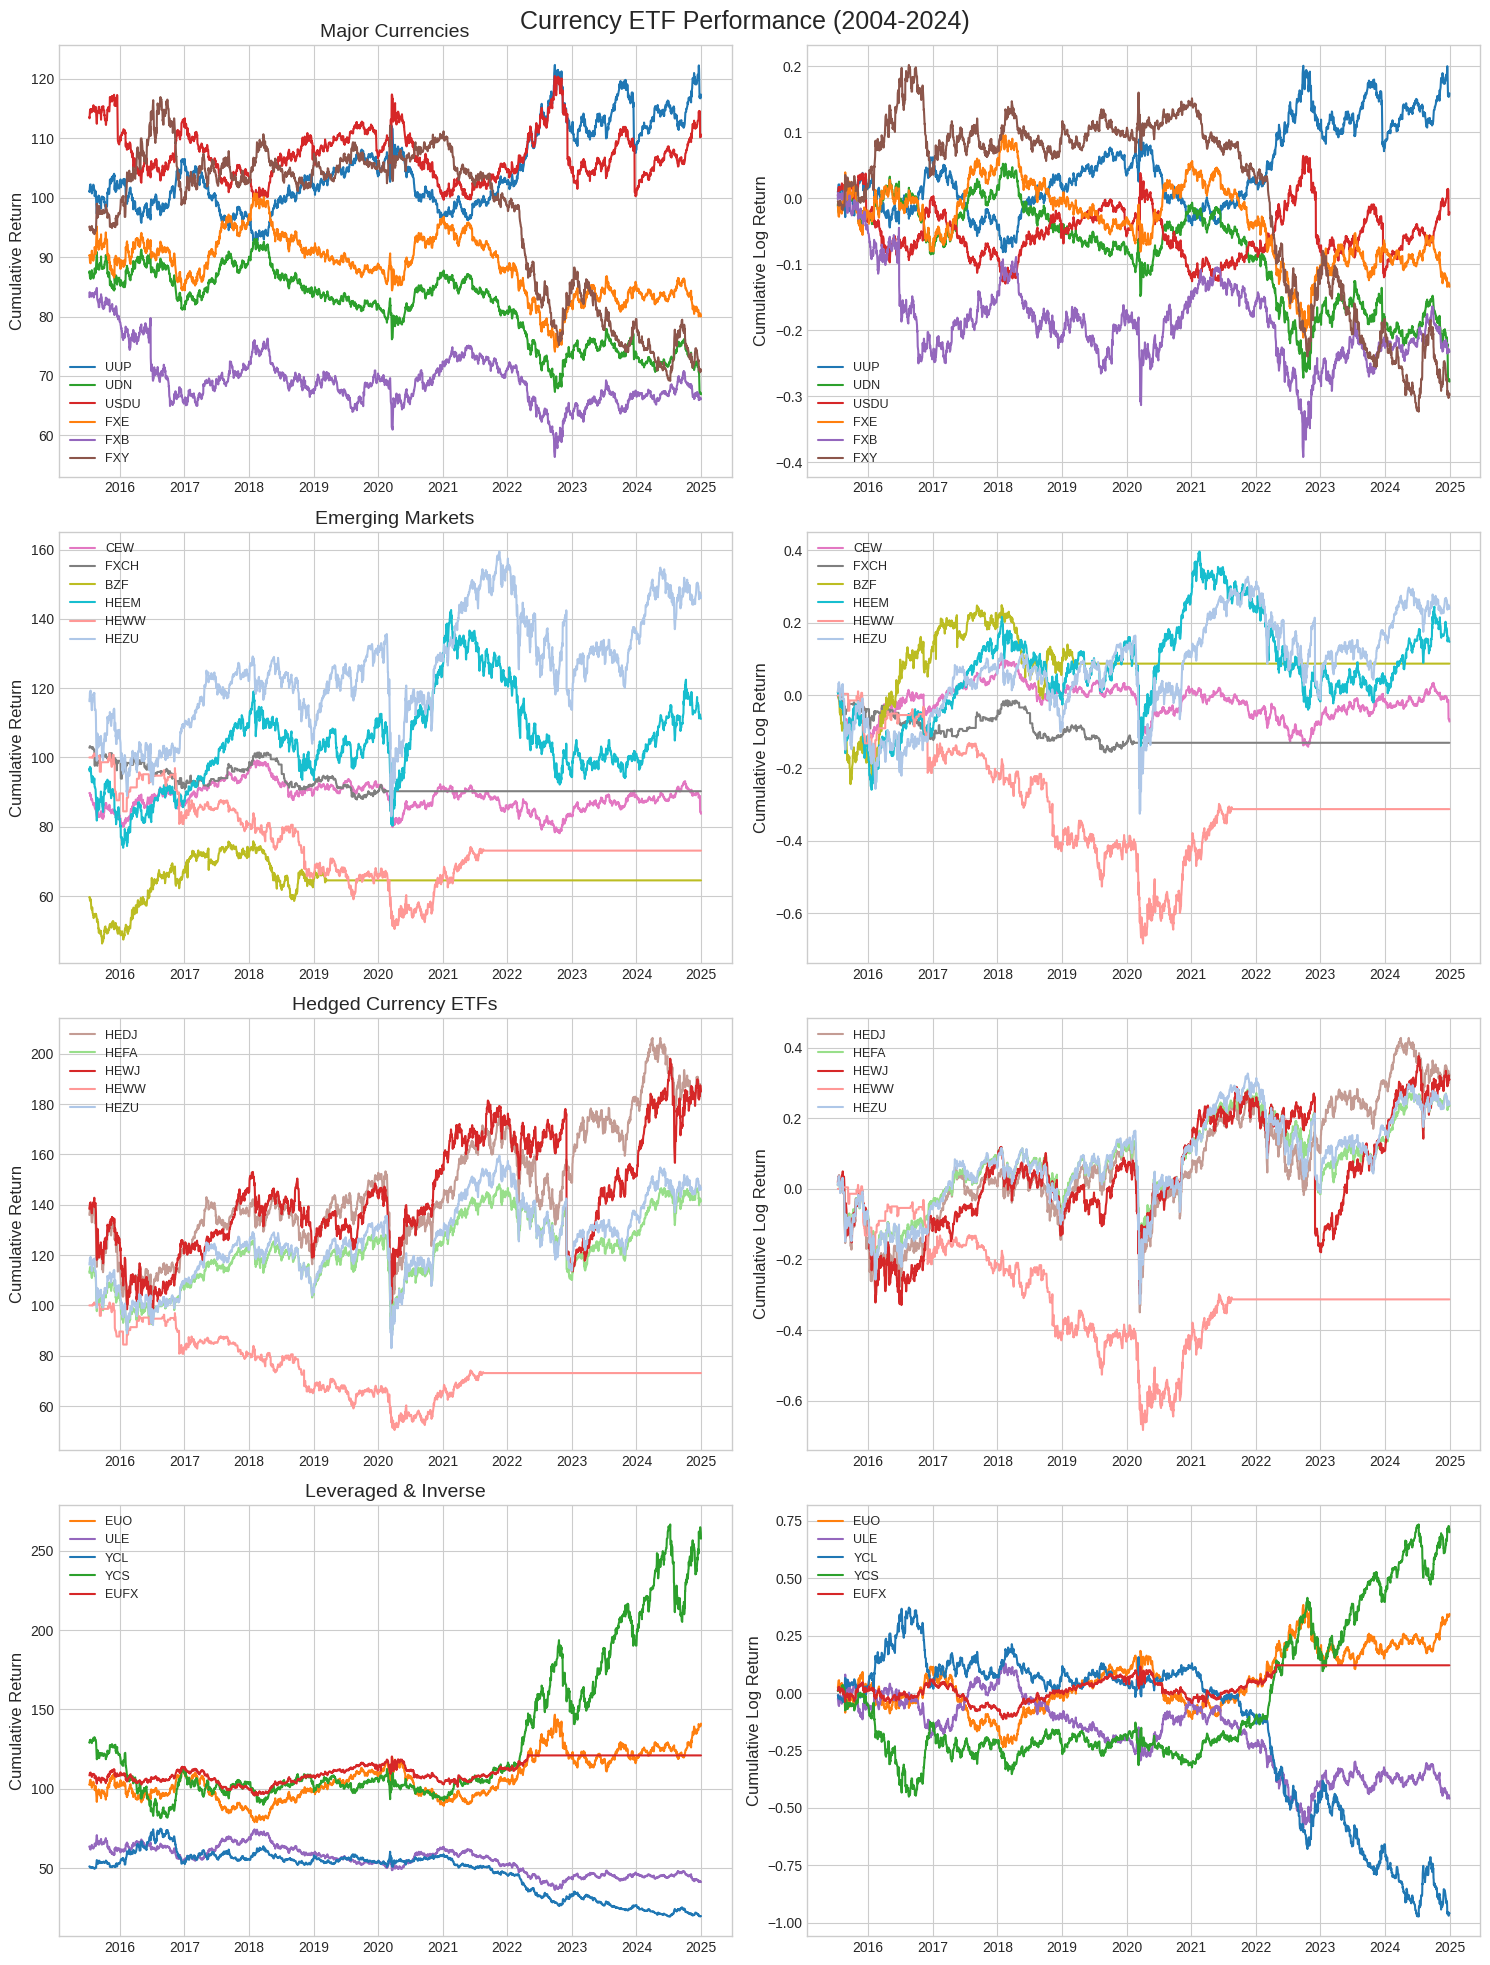

In [11]:
# Create figure
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# List of categories
categories = ["Major Currencies", "Emerging Markets", "Hedged Currency ETFs", "Leveraged & Inverse"]

# Generate plots
for i, category in enumerate(categories):
    plot_category(axes[i, 0], axes[i, 1], category, etf_categories[category], etf_data)

# Set main title
fig.suptitle('Currency ETF Performance (2004-2024)', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.show()
